In [133]:
# -*- coding: utf-8 -*-
import h5py
import os
import pickle
import numpy as np
import pandas as pd
import argparse
from wang_args import WangClassifier

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.metrics.functional.classification import auroc, stat_scores
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, roc_auc_score, accuracy_score

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import GuidedGradCam
from captum.attr import visualization as viz

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def cmap_alpha(threshold=0.5, base='jet'):
    # base = 'gist_rainbow'
    ncolors = 256
    color_array = plt.get_cmap(base)(range(ncolors))
    alpha_array = np.hstack((np.zeros(ncolors - int(ncolors * threshold)), np.linspace(0.5, 0, int(ncolors * threshold))))
    color_array[:, -1] = alpha_array
    return LinearSegmentedColormap.from_list(name='cmap_alpha', colors=color_array)

jet_alpha = cmap_alpha(0.5, 'jet')


In [49]:
args = argparse.Namespace(mri_sequences='TBAKDEF', data_sequences='TBAKDEF', valid_dir='tbakd3_npy/uint8/5folds/4/train_bal', eval_batch_size=1, pooling=True)
f4 = np.vectorize(lambda x: f'{x:.4f}')
ckpt = '/net/scratch/hanliu/radiology/prostatex/results/wang-fold-bal/z4ktwfw9/checkpoints/epoch=102-valid_acc=0.81.ckpt' # splendid-night-1029
model = WangClassifier.load_from_checkpoint(ckpt, **vars(args))
model.w_ensemble.require_grads = True
_ = model.eval()

In [61]:
batch = list(iter(model.valid_dataloader()))[196]
input, label = batch
input = input[:, model.mri_index]

In [62]:
saliency = Saliency(model)
grads = saliency.attribute(input, target=label)

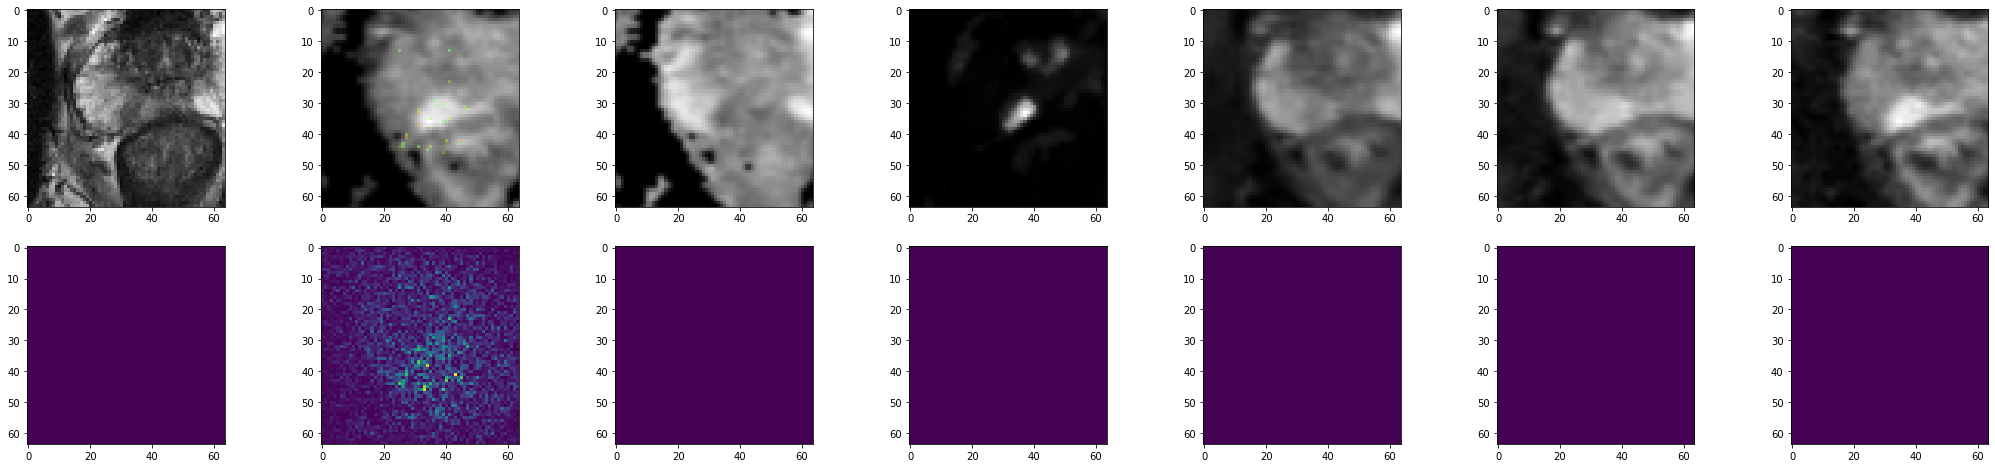

In [161]:
fig, ax = plt.subplots(2, model.num_sequences, figsize=(36, 8))
for i in range(model.num_sequences):
    ax[0, i].imshow(batch[0].squeeze()[i], cmap='gray')
    ax[0, i].imshow(grads.squeeze()[i], cmap=cmap_alpha(0.5))
    ax[1, i].imshow(grads.squeeze()[i])

In [64]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, **kwargs)
    return tensor_attributions

In [65]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input, target=label, baselines=input * 0, return_convergence_delta=True)
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0080], dtype=torch.float64)


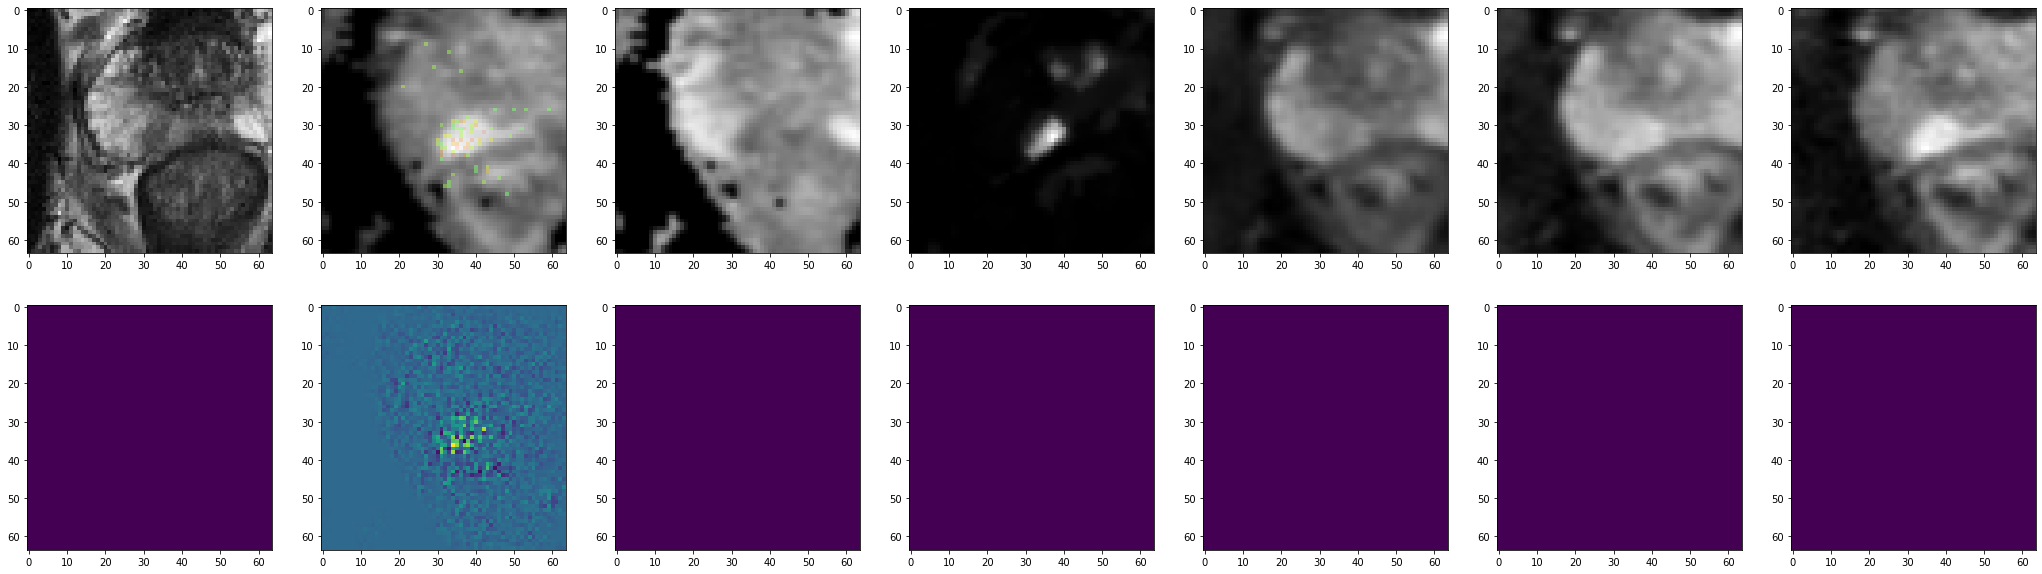

In [168]:
fig, ax = plt.subplots(2, model.num_sequences, figsize=(36, 10))
for i in range(model.num_sequences):
    ax[0, i].imshow(batch[0].squeeze()[i], cmap='gray')
    ax[0, i].imshow(attr_ig.squeeze()[i], cmap=cmap_alpha(0.5))
    ax[1, i].imshow(attr_ig.squeeze()[i])

In [67]:
dl = DeepLift(model)
attr_dl = attribute_image_features(dl, input, target=label, baselines=input * 0)

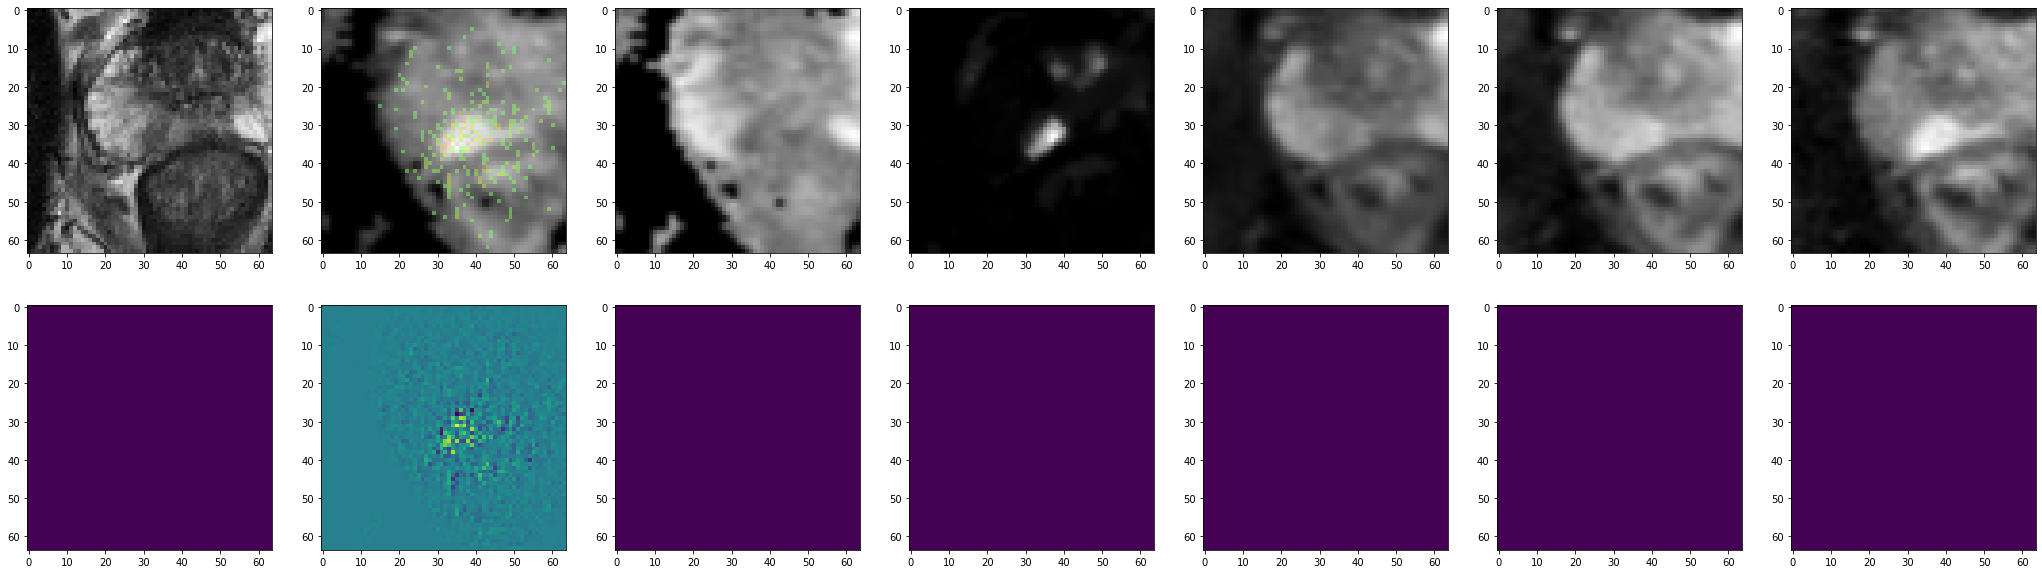

In [169]:
fig, ax = plt.subplots(2, model.num_sequences, figsize=(36, 10))
for i in range(model.num_sequences):
    ax[0, i].imshow(batch[0].squeeze().detach()[i], cmap='gray')
    ax[0, i].imshow(attr_dl.squeeze().detach()[i], cmap=cmap_alpha(0.5))
    ax[1, i].imshow(attr_dl.squeeze().detach()[i])

In [69]:
def guided_gc(model, input, target, iconv=4):
    
    layers = []
    for s in range(model.num_sequences):
        layers.append(model.conv[s][iconv].layer[-1])
    
    guided_gcs = [GuidedGradCam(model, ly) for ly in layers]
    attr_gcs = [ggc.attribute(input, target) for ggc in guided_gcs]
    return attr_gcs

In [200]:
attr_gcs = guided_gc(model, input, target=label, iconv=4)

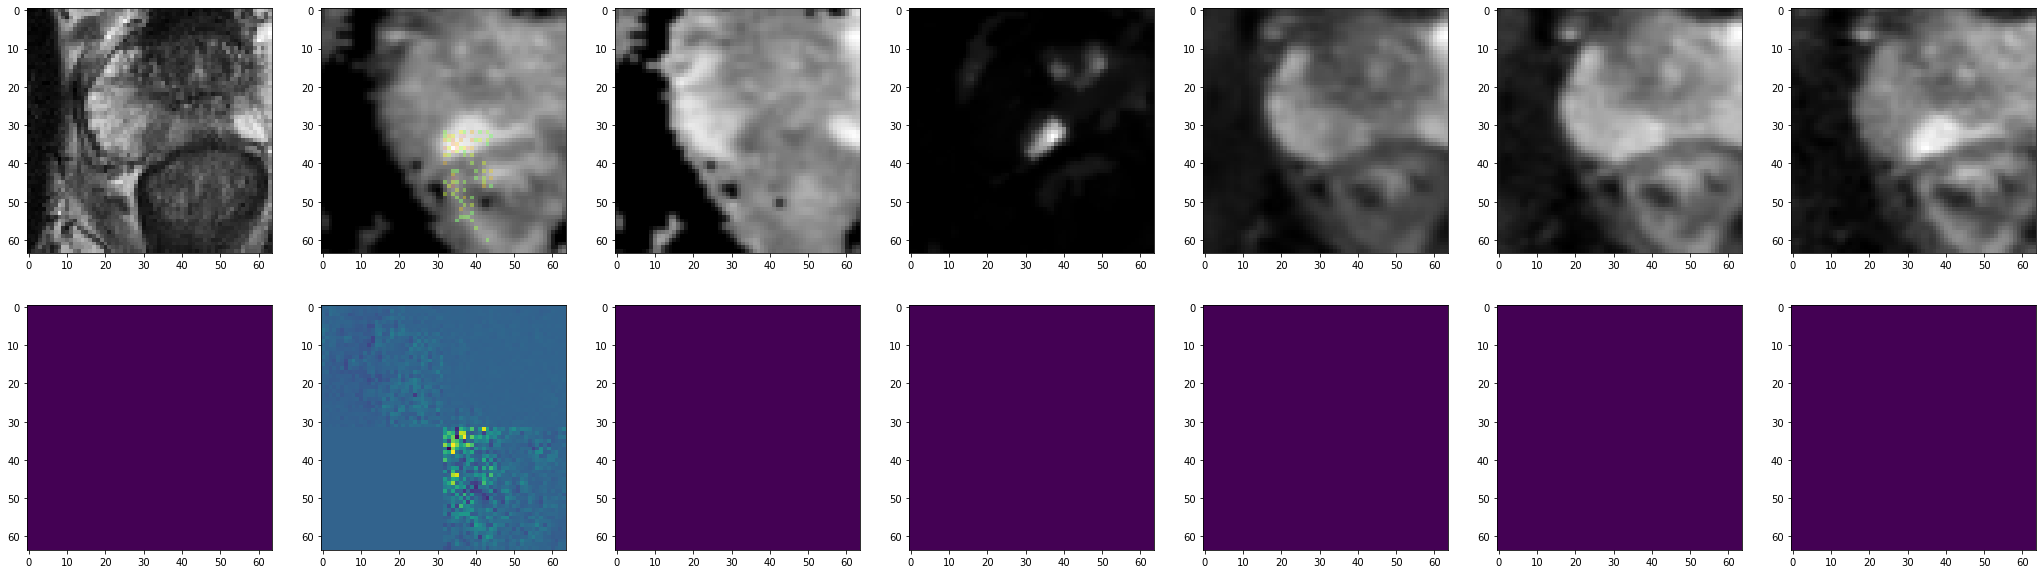

In [201]:
fig, ax = plt.subplots(2, model.num_sequences, figsize=(36, 10))
for i in range(model.num_sequences):
    ax[0, i].imshow(batch[0].squeeze().detach()[i], cmap='gray')
    ax[0, i].imshow(attr_gcs[1].squeeze().detach()[i], cmap=cmap_alpha(0.5))
    ax[1, i].imshow(attr_gcs[1].squeeze().detach()[i])